In [198]:
import json

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from PIL import Image
import pandas as pd
import numpy as np
import cv2
import os

In [199]:
# img_h, img_w = 32, 32
img_h, img_w = 224, 224  #经过处理后你的图片的尺寸大小
means, stdevs = [], []
img_list = []

imgs_path = "./flower_data/train/1/"  #数据集的路径采用绝对引用
imgs_path_list = os.listdir(imgs_path)

len_ = len(imgs_path_list)
i = 0
for item in imgs_path_list:
    img = cv2.imread(os.path.join(imgs_path, item))
    img = cv2.resize(img, (img_w, img_h))
    img = img[:, :, :, np.newaxis]
    img_list.append(img)
    i += 1
    print(i, '/', len_)

imgs = np.concatenate(img_list, axis=3)
imgs = imgs.astype(np.float32) / 255.

for i in range(3):
    pixels = imgs[:, :, i, :].ravel()  # 拉成一行
    means.append(np.mean(pixels))
    stdevs.append(np.std(pixels))

# BGR --> RGB ， CV读取的需要转换，PIL读取的不用转换
means.reverse()
stdevs.reverse()

print("normMean = {}".format(means))
print("normStd = {}".format(stdevs))

1 / 27
2 / 27
3 / 27
4 / 27
5 / 27
6 / 27
7 / 27
8 / 27
9 / 27
10 / 27
11 / 27
12 / 27
13 / 27
14 / 27
15 / 27
16 / 27
17 / 27
18 / 27
19 / 27
20 / 27
21 / 27
22 / 27
23 / 27
24 / 27
25 / 27
26 / 27
27 / 27
normMean = [0.4399509, 0.42170265, 0.38204673]
normStd = [0.30169594, 0.23485409, 0.3215254]


In [200]:
## 处理标签
import json

with open("./flower_name.json", "r", encoding="utf8") as pf:
    class_name = json.load(pf)
# print(class_name)

sweet pea


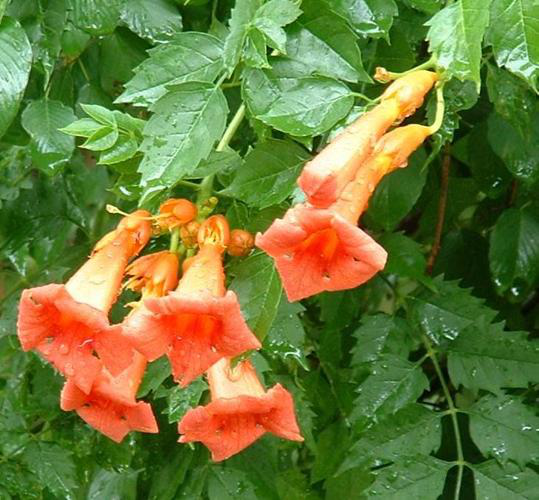

In [201]:
## 加载数据并查看
train_path = "./flower_data/train/"
valid_path = "./flower_data/valid/"

data_transforms = transforms.Compose([
    transforms.Resize(224),  # 缩放图片(Image)，保持长宽比不变，最短边为32像素
    transforms.CenterCrop(224),  # 从图片中间切出32*32的图片
    transforms.ToTensor(),  # 将图片(Image)转成Tensor，归一化至[0, 1]
    transforms.Normalize(mean=means, std=stdevs)  # 标准化至[-1, 1]，规定均值和标准差
])

train_data = datasets.ImageFolder(root=train_path, transform=None)
img, label = train_data[100]
print(class_name[str(label + 1)])
img

In [202]:
## 数据集制作

train_data = datasets.ImageFolder(root=train_path, transform=data_transforms)
valid_data = datasets.ImageFolder(root=valid_path, transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=4, shuffle=True)

In [203]:
from typing import Optional

import numpy as np
import torch
import torch.nn as nn
from torch import Tensor


def _make_divisible(ch, divisor=8, min_ch=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_ch is None:
        min_ch = divisor
    new_ch = max(min_ch, int(ch + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_ch < 0.9 * ch:
        new_ch += divisor
    return new_ch


def _mcfg(**kwargs):
    cfg = dict(se_ratio=0., bottle_ratio=1., stem_width=32)
    cfg.update(**kwargs)
    return cfg


model_cfgs = {
    "regnetx_200mf": _mcfg(w0=24, wa=36.44, wm=2.49, group_w=8, depth=13),
    "regnetx_400mf": _mcfg(w0=24, wa=24.48, wm=2.54, group_w=16, depth=22),
    "regnetx_600mf": _mcfg(w0=48, wa=36.97, wm=2.24, group_w=24, depth=16),
    "regnetx_800mf": _mcfg(w0=56, wa=35.73, wm=2.28, group_w=16, depth=16),
    "regnetx_1.6gf": _mcfg(w0=80, wa=34.01, wm=2.25, group_w=24, depth=18),
    "regnetx_3.2gf": _mcfg(w0=88, wa=26.31, wm=2.25, group_w=48, depth=25),
    "regnetx_4.0gf": _mcfg(w0=96, wa=38.65, wm=2.43, group_w=40, depth=23),
    "regnetx_6.4gf": _mcfg(w0=184, wa=60.83, wm=2.07, group_w=56, depth=17),
    "regnetx_8.0gf": _mcfg(w0=80, wa=49.56, wm=2.88, group_w=120, depth=23),
    "regnetx_12gf": _mcfg(w0=168, wa=73.36, wm=2.37, group_w=112, depth=19),
    "regnetx_16gf": _mcfg(w0=216, wa=55.59, wm=2.1, group_w=128, depth=22),
    "regnetx_32gf": _mcfg(w0=320, wa=69.86, wm=2.0, group_w=168, depth=23),
    "regnety_200mf": _mcfg(w0=24, wa=36.44, wm=2.49, group_w=8, depth=13, se_ratio=0.25),
    "regnety_400mf": _mcfg(w0=48, wa=27.89, wm=2.09, group_w=8, depth=16, se_ratio=0.25),
    "regnety_600mf": _mcfg(w0=48, wa=32.54, wm=2.32, group_w=16, depth=15, se_ratio=0.25),
    "regnety_800mf": _mcfg(w0=56, wa=38.84, wm=2.4, group_w=16, depth=14, se_ratio=0.25),
    "regnety_1.6gf": _mcfg(w0=48, wa=20.71, wm=2.65, group_w=24, depth=27, se_ratio=0.25),
    "regnety_3.2gf": _mcfg(w0=80, wa=42.63, wm=2.66, group_w=24, depth=21, se_ratio=0.25),
    "regnety_4.0gf": _mcfg(w0=96, wa=31.41, wm=2.24, group_w=64, depth=22, se_ratio=0.25),
    "regnety_6.4gf": _mcfg(w0=112, wa=33.22, wm=2.27, group_w=72, depth=25, se_ratio=0.25),
    "regnety_8.0gf": _mcfg(w0=192, wa=76.82, wm=2.19, group_w=56, depth=17, se_ratio=0.25),
    "regnety_12gf": _mcfg(w0=168, wa=73.36, wm=2.37, group_w=112, depth=19, se_ratio=0.25),
    "regnety_16gf": _mcfg(w0=200, wa=106.23, wm=2.48, group_w=112, depth=18, se_ratio=0.25),
    "regnety_32gf": _mcfg(w0=232, wa=115.89, wm=2.53, group_w=232, depth=20, se_ratio=0.25)
}


def generate_width_depth(wa, w0, wm, depth, q=8):
    """Generates per block widths from RegNet parameters."""
    assert wa > 0 and w0 > 0 and wm > 1 and w0 % q == 0
    widths_cont = np.arange(depth) * wa + w0
    width_exps = np.round(np.log(widths_cont / w0) / np.log(wm))
    widths_j = w0 * np.power(wm, width_exps)
    widths_j = np.round(np.divide(widths_j, q)) * q
    num_stages, max_stage = len(np.unique(widths_j)), width_exps.max() + 1
    assert num_stages == int(max_stage)
    assert num_stages == 4
    widths = widths_j.astype(int).tolist()
    return widths, num_stages


def adjust_width_groups_comp(widths: list, groups: list):
    """Adjusts the compatibility of widths and groups."""
    groups = [min(g, w_bot) for g, w_bot in zip(groups, widths)]
    # Adjust w to an integral multiple of g
    widths = [int(round(w / g) * g) for w, g in zip(widths, groups)]
    return widths, groups


class ConvBNAct(nn.Module):
    def __init__(self,
                 in_c: int,
                 out_c: int,
                 kernel_s: int = 1,
                 stride: int = 1,
                 padding: int = 0,
                 groups: int = 1,
                 act: Optional[nn.Module] = nn.ReLU(inplace=True)):
        super(ConvBNAct, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_c,
                              out_channels=out_c,
                              kernel_size=kernel_s,
                              stride=stride,
                              padding=padding,
                              groups=groups,
                              bias=False)

        self.bn = nn.BatchNorm2d(out_c)
        self.act = act if act is not None else nn.Identity()

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x


class RegHead(nn.Module):
    def __init__(self,
                 in_unit: int = 368,
                 out_unit: int = 1000,
                 output_size: tuple = (1, 1),
                 drop_ratio: float = 0.25):
        super(RegHead, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(output_size)

        if drop_ratio > 0:
            self.dropout = nn.Dropout(p=drop_ratio)
        else:
            self.dropout = nn.Identity()

        self.fc = nn.Linear(in_features=in_unit, out_features=out_unit)

    def forward(self, x: Tensor) -> Tensor:
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


class SqueezeExcitation(nn.Module):
    def __init__(self, input_c: int, expand_c: int, se_ratio: float = 0.25):
        super(SqueezeExcitation, self).__init__()
        squeeze_c = int(input_c * se_ratio)
        self.fc1 = nn.Conv2d(expand_c, squeeze_c, 1)
        self.ac1 = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(squeeze_c, expand_c, 1)
        self.ac2 = nn.Sigmoid()

    def forward(self, x: Tensor) -> Tensor:
        scale = x.mean((2, 3), keepdim=True)
        scale = self.fc1(scale)
        scale = self.ac1(scale)
        scale = self.fc2(scale)
        scale = self.ac2(scale)
        return scale * x


class Bottleneck(nn.Module):
    def __init__(self,
                 in_c: int,
                 out_c: int,
                 stride: int = 1,
                 group_width: int = 1,
                 se_ratio: float = 0.,
                 drop_ratio: float = 0.):
        super(Bottleneck, self).__init__()

        self.conv1 = ConvBNAct(in_c=in_c, out_c=out_c, kernel_s=1)
        self.conv2 = ConvBNAct(in_c=out_c,
                               out_c=out_c,
                               kernel_s=3,
                               stride=stride,
                               padding=1,
                               groups=out_c // group_width)

        if se_ratio > 0:
            self.se = SqueezeExcitation(in_c, out_c, se_ratio)
        else:
            self.se = nn.Identity()

        self.conv3 = ConvBNAct(in_c=out_c, out_c=out_c, kernel_s=1, act=None)
        self.ac3 = nn.ReLU(inplace=True)

        if drop_ratio > 0:
            self.dropout = nn.Dropout(p=drop_ratio)
        else:
            self.dropout = nn.Identity()

        if (in_c != out_c) or (stride != 1):
            self.downsample = ConvBNAct(in_c=in_c, out_c=out_c, kernel_s=1, stride=stride, act=None)
        else:
            self.downsample = nn.Identity()

    def zero_init_last_bn(self):
        nn.init.zeros_(self.conv3.bn.weight)

    def forward(self, x: Tensor) -> Tensor:
        shortcut = x
        x = self.conv1(x)
        x = self.conv2(x)

        x = self.se(x)
        x = self.conv3(x)

        x = self.dropout(x)

        shortcut = self.downsample(shortcut)

        x += shortcut
        x = self.ac3(x)
        return x


class RegStage(nn.Module):
    def __init__(self,
                 in_c: int,
                 out_c: int,
                 depth: int,
                 group_width: int,
                 se_ratio: float):
        super(RegStage, self).__init__()
        for i in range(depth):
            block_stride = 2 if i == 0 else 1
            block_in_c = in_c if i == 0 else out_c

            name = "b{}".format(i + 1)
            self.add_module(name,
                            Bottleneck(in_c=block_in_c,
                                       out_c=out_c,
                                       stride=block_stride,
                                       group_width=group_width,
                                       se_ratio=se_ratio))

    def forward(self, x: Tensor) -> Tensor:
        for block in self.children():
            x = block(x)
        return x


class RegNet(nn.Module):
    """RegNet model.
    Paper: https://arxiv.org/abs/2003.13678
    Original Impl: https://github.com/facebookresearch/pycls/blob/master/pycls/models/regnet.py
    and refer to: https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/regnet.py
    """

    def __init__(self,
                 cfg: dict,
                 in_c: int = 3,
                 num_classes: int = 1000,
                 zero_init_last_bn: bool = True):
        super(RegNet, self).__init__()

        # RegStem
        stem_c = cfg["stem_width"]
        self.stem = ConvBNAct(in_c, out_c=stem_c, kernel_s=3, stride=2, padding=1)

        # build stages
        input_channels = stem_c
        stage_info = self._build_stage_info(cfg)
        for i, stage_args in enumerate(stage_info):
            stage_name = "s{}".format(i + 1)
            self.add_module(stage_name, RegStage(in_c=input_channels, **stage_args))
            input_channels = stage_args["out_c"]

        # RegHead
        self.head = RegHead(in_unit=input_channels, out_unit=num_classes)

        # initial weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, mode="fan_out", nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                nn.init.zeros_(m.bias)

        if zero_init_last_bn:
            for m in self.modules():
                if hasattr(m, "zero_init_last_bn"):
                    m.zero_init_last_bn()

    def forward(self, x: Tensor) -> Tensor:
        for layer in self.children():
            x = layer(x)
        return x

    @staticmethod
    def _build_stage_info(cfg: dict):
        wa, w0, wm, d = cfg["wa"], cfg["w0"], cfg["wm"], cfg["depth"]
        widths, num_stages = generate_width_depth(wa, w0, wm, d)

        stage_widths, stage_depths = np.unique(widths, return_counts=True)
        stage_groups = [cfg['group_w'] for _ in range(num_stages)]
        stage_widths, stage_groups = adjust_width_groups_comp(stage_widths, stage_groups)

        info = []
        for i in range(num_stages):
            info.append(dict(out_c=stage_widths[i],
                             depth=stage_depths[i],
                             group_width=stage_groups[i],
                             se_ratio=cfg["se_ratio"]))

        return info


def create_regnet(model_name="RegNetX_200MF", num_classes=1000):
    model_name = model_name.lower().replace("-", "_")
    if model_name not in model_cfgs.keys():
        print("support model name: \n{}".format("\n".join(model_cfgs.keys())))
        raise KeyError("not support model name: {}".format(model_name))

    model = RegNet(cfg=model_cfgs[model_name], num_classes=num_classes)
    return model

In [204]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc.
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [205]:
# from models import create_regnet
# from models import ResNet
# 网络例化
# net = ResNet(num_class=102)
net = create_regnet(model_name="regnetx_600mf", num_classes=102).to(device)
# 训练次数定义
epochs = 50
# 优化器定义
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
# 损失函数定义
loss_func = torch.nn.CrossEntropyLoss().to(device)


In [206]:
## 开始训练

for epoch in range(epochs):
    losses = []
    val_loss = []
    net.train()
    for data in train_loader:
        img, label = data
        img = img.to(device)
        label = label.to(device)
        out = net(img)
        losses = loss_func(out, label)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    net.eval()
    for data in valid_loader:
        img, label = data
        img = img.to(device)
        label = label.to(device)
        out = net(img)
        val_loss = loss_func(out, label)

    if epoch % 10 == 0:
        path = "./checkpoint/model" + str(epoch) + ".pth"
        torch.save(net.state_dict(), path)
    print("当前step : {}/{} ,训练集损失 : {:.5f} , 验证集损失 : {:.5f}".format(epoch + 1, epochs, losses, val_loss))


KeyboardInterrupt: 

In [281]:
## 模型加载及预测
# 模型加载
PATH = "./checkpoint/model40.pth"
img_path = "./flower_data/train/3/image_06625.jpg"
# img_path = "./flower_data/flower_test/moon_orchid_2.jpg"
model = create_regnet(model_name="regnetx_600mf", num_classes=102)
model.load_state_dict(torch.load(PATH))
model.eval()

# 数据预处理
test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),  # 缩放图片(Image)，保持长宽比不变，最短边为224像素
    transforms.ToTensor(),  # 将图片(Image)转成Tensor，归一化至[0, 1]
    transforms.Normalize(mean=means, std=stdevs)  # 标准化至[-1, 1]，规定均值和标准差
])
img = cv2.imread(img_path)  # 读取图像
test_data = test_transforms(img)
out = model(test_data.unsqueeze(0))
out = out.tolist()
[out] = out
result = out.index(max(out))+1
print(result)
print(class_name[str(result)])

42
daffodil
